# Описание

Для понимания структуры данных о клиентах, совершающих платежные операции очень часто используются алгоритмы кластеризации, изначально мы не знаем какие классы удастся выделить и сколько их будет. В общем случае нам интересно выделить пользователей, которые приносят прибыль, клиентов которые представляют некий портрет среднего пользователя продукта и пользователей, которые по каким-то причинам не очень охотно платят. Необходимо разработать модель кластеризации, которая позволит разделить клиентов на классы по их платежному поведению. Может быть ситуация, когда  пользователь не попал ни в один из выделенных классов, таких пользователей можно отнести к классу Другие. Возможно, вы выделите еще классы.

# Задание 

Обработайте данные: 

1) Удалите столбец CustomerId, так как для каждого пользователя это значение уникально. 

2)Так как признак Recency - время последнего платежа пользователя за анализируемый период времени, и каждое значение содержит 2019 год, то преобразуйте его в количество дней, прошедших с 2018 года, используя следующий код:

from datetime import datetime

data['Recency'] = data['Recency'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month*30 + datetime.strptime(x, '%Y-%m-%d').day)

data['Recency'] = data['Recency'] - data['Recency'].min()

3) Определите оптимальное число кластеров. Выполните кластерный анализ, используя метод k-средних.

4) Визуализируйте кластеры.

5) Интерпретируйте результаты кластерного анализа: что представляют собой полученные кластеры? чем объекты в каждом из получившихся кластеров похожи друг на друга? чем объекты из разных кластеров отличаются друг от друга?

# Загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics

# Загрузка набора данных в объект DataFrame

- CustomerId - уникальный идентификатор пользователя
- Monetary - объем средств, который пользователь принес в продукт за анализируемый период времени
- Recency - время последнего платежа пользователя за анализируемый период времени
- Frequency - количество платежей, которое пользователь совершил за анализируемый период времени
- factor_* - замаскированные показатели

In [ ]:
%%capture
!wget https://www.dropbox.com/s/pah8yvu0kj5s1mb/KA_segm.csv


In [ ]:
data = pd.read_csv("KA_segm.csv")
print(data.shape)
data

(16000, 8)


,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194
...,...,...,...,...,...,...,...,...
15995,3e0cc750-5787-4843-8192-92eb92d0baf2,110.00,2019-05-31,5,0.22,0.92,0.279858,0.012416
15996,48d1512b-9291-4c69-84da-2e896e8b5250,175.00,2019-05-16,9,0.66,0.55,0.045826,0.025403
15997,6c09d459-a312-4162-a8ce-a4ea43bf177a,94.21,2019-03-06,2,0.41,0.80,0.438510,0.665808
15998,1f0cb9c5-111a-4927-8ed1-01402929ee65,3.35,2019-01-05,1,0.75,0.17,0.009277,0.572111


# 1. Удалим столбец CustomerId, так как для каждого пользователя это значение уникально.

In [ ]:
data = data.drop('CustomerId', axis=1)
data

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194
...,...,...,...,...,...,...,...
15995,110.00,2019-05-31,5,0.22,0.92,0.279858,0.012416
15996,175.00,2019-05-16,9,0.66,0.55,0.045826,0.025403
15997,94.21,2019-03-06,2,0.41,0.80,0.438510,0.665808
15998,3.35,2019-01-05,1,0.75,0.17,0.009277,0.572111


# 2. Преобразуем Recency в количество дней, прошедших с 2018 года.

In [ ]:
from datetime import datetime
data['Recency'] = data['Recency'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month*30 + datetime.strptime(x, '%Y-%m-%d').day)
data['Recency'] = data['Recency'] - data['Recency'].min()
data

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,153,6,0.35,0.08,0.609740,0.949383
1,170.00,144,4,0.66,0.16,0.942272,0.479846
2,70.75,144,6,0.92,0.20,0.323030,0.007076
3,75.00,79,10,0.35,0.78,0.876833,0.088974
4,94.51,99,5,0.51,0.44,0.912099,0.206194
...,...,...,...,...,...,...,...
15995,110.00,150,5,0.22,0.92,0.279858,0.012416
15996,175.00,135,9,0.66,0.55,0.045826,0.025403
15997,94.21,65,2,0.41,0.80,0.438510,0.665808
15998,3.35,4,1,0.75,0.17,0.009277,0.572111


In [ ]:
data.info()

# 3. Определим оптимальное число кластеров. Выполним кластерный анализ, используя метод k-средних.

Рассмотрим корелляцию между признаками на тепловой карте. Для её построения используем тип графика - heatmap, а на вход подадим корелляционную матрицу нашего DataSeta, который представляет собой матрицу попарных кореляций признаков.

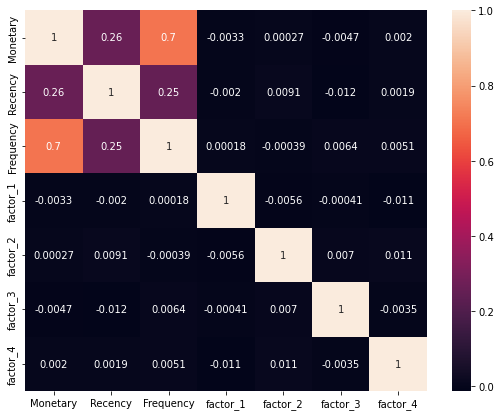

In [ ]:
plt.figure(figsize=[9,7])
sns.heatmap(data.corr(), annot=True)
plt.show()

# Нормализация данных
Посмотрим наши переменные. Они замерены в различных единицах измерения. Имеет смысл првиести все переменные к единице, чтобы избежать влияние масштаба наших переменных на результат модели. Вызовем метод StandardScaler(), который нормализцет объекты, т.е. каждый столбец Х. На вход данный метод принимает массив, поэтому преобразуем наш DataSet используя библиотеку numpy. Затем методом fit преобразуем наши данные и видим, что наши данные теперь стнадартизированы, они находятся в диапозоне от -1 до 1. Таким образом, все элементы будут иметь одинаковый вес.

In [ ]:
X = np.asarray(data)
scale = StandardScaler()
X = scale.fit_transform(X)
X

array([[-0.16446977,  0.90557931,  0.39488058, ..., -1.43549584,
         0.39542918,  1.56327193],
       [ 0.22261916,  0.72861018,  0.00950199, ..., -1.16067021,
         1.54596103, -0.06441357],
       [-0.32937188,  0.72861018,  0.39488058, ..., -1.0232574 ,
        -0.59655788, -1.70330595],
       ...,
       [-0.19889621, -0.82478553, -0.3758766 , ...,  1.0379348 ,
        -0.19700992,  0.58024063],
       [-0.70422524, -2.02424298, -0.56856589, ..., -1.12631701,
        -1.68211376,  0.2554301 ],
       [ 1.19590311,  1.08254845,  2.70715212, ..., -0.74843177,
        -1.4765516 , -0.1434807 ]])

# Понижение размерности методом главных компонент

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=7)
pca_val7 = pca.fit_transform(X)
pca_X= pd.DataFrame(pca_val7)

In [ ]:
pca_X.shape

(16000, 7)

In [ ]:
pca

PCA(n_components=7)

In [ ]:
pd.DataFrame(pca.components_.T, columns=['PC_' + str(i) for i in range(7)])

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,0.653021,-0.012010,0.009114,0.014901,0.012210,0.265957,0.708683
1,0.386970,0.019277,-0.041684,-0.046914,-0.060447,-0.917717,-0.009282
2,0.650947,-0.011232,0.022627,0.016407,0.024012,0.277932,-0.705364
3,-0.003370,-0.537098,0.187370,-0.749095,0.339445,-0.005314,0.003490
4,0.004081,0.560247,0.352255,-0.545509,-0.510840,0.059029,-0.000676
5,-0.004124,0.088109,0.872962,0.315529,0.352473,-0.078997,0.011006
6,0.006350,0.623894,-0.276429,-0.197551,0.703706,-0.007947,0.003288


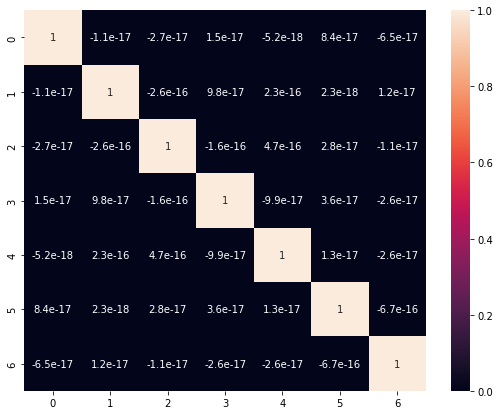

In [ ]:
### Проверка
plt.figure(figsize=[9, 7])

sns.heatmap(pca_X.corr(), annot=True)
plt.show()

# Используем метод локтя для поиска оптимального количества кластеров.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0, 0.5, 'Sum of squared errors')

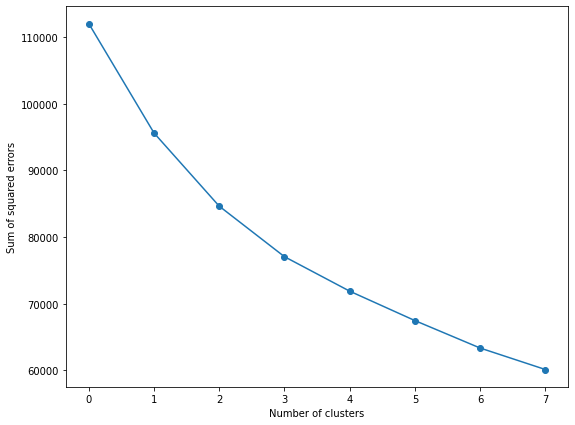

In [ ]:
n_cluster=9
cost=[]
for i in range(1, n_cluster):
  kmean= KMeans(i)
  kmean.fit(pca_X)
  cost.append(kmean.inertia_)
plt.figure(figsize=[9, 7])
plt.plot(cost, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared errors")

Снижение дисперссии замедляется в точке 4 - это точка локоть, зн-т, количество кластеров будет - 4.

# 4. Визуализируем кластеры.

Построение модели кластеризации

In [ ]:
#описываем модель
kmean = KMeans(n_clusters = 4)
# Предсказание на наборе данных
k_means_predicted = kmean.fit(pca_X)
labels = kmean.labels_
labels

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 1, ..., 2, 2, 3], dtype=int32)

In [ ]:
labels.replace('U+200B','')
DF=pd.DataFrame({​​​​​​​​'clusters':labels}​​​​​)

SyntaxError: ignored

In [ ]:
clusters = pd.concat([data, pd.DataFrame({​​​​​​​​'cluster':labels}​​​​​)], axis=1)
clusters.head()

SyntaxError: ignored

In [ ]:
clusters[['cluster', 'PURCHASES', 'BALANCE', 'CREDIT_LIMIT']].groupby('cluster').mean().plot()
plt.show()

In [ ]:
## Рассмотрим всего нескольких столбцов для понимания кластеров
k_df_columns= ["PURCHASES", "CASH_ADVANCE", "PURCHASES_TRX", "CASH_ADVANCE_TRX", "MINIMUM_PAYMENTS",
              "ONEOFF_PURCHASES", "INSTALLMENTS_PURCHASES"]

# mEAN VALUE GIVES A GOOD INDICATION OF THE DISTRIBUTION OF DATA. So we are findinf mean value
cluster_4=clusters.groupby('clusters').apply(lambda x: x[k_df_columns].mean()).T
cluster_4


In [ ]:
pca = PCA(2)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

In [ ]:
x, y = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'wellow'}

df = pd.dataFrame({'x': x, 'y': y, 'label':labels})
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13))
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()